# Batch Normalization

In [127]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

In [171]:
img_size = 224
batch_size = 4
n = 20

In [141]:
def load_batch(batch_size,img_size,last_it):
    data_dir = '../numerical_examples/data/small/train/dogs/'
    data_files = os.listdir(data_dir)
    array = np.array(
        [
            np.array(Image.open(f'{data_dir}/{data_files[i]}').resize((img_size, img_size), Image.ANTIALIAS))
            for i
            in range(last_it,batch_size+last_it)
        ]
    )
    return array

In [142]:
def batch_normalization2d(array):
    assert array.ndim == 4
    mean = array.mean(axis=(0,1,2))
    std = array.std(axis=(0,1,2))
    array = (array - mean)/std
    return array
    
        

In [167]:
def visualize_batch(array):
    img = np.hstack(array)
    plt.imshow(img)
    plt.axis('off')
    plt.pause(0.5)

In [168]:
def normalize_flow(img_size,batch_size,n):
    num_batches = n//batch_size
    last_batch_num = 0
    for i in range(num_batches):
        batch = load_batch(batch_size,img_size,last_batch_num)
        normalized_batch = batch_normalization2d(batch)
        visualize_batch(normalized_batch)
        last_batch_num += batch_size
    return
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


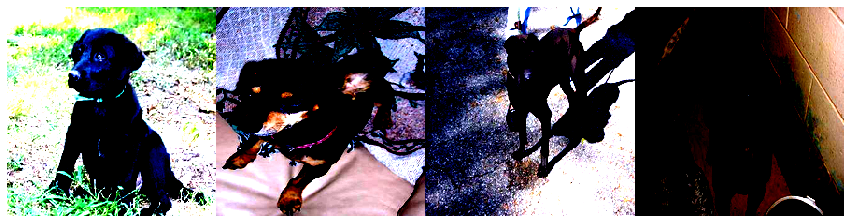

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


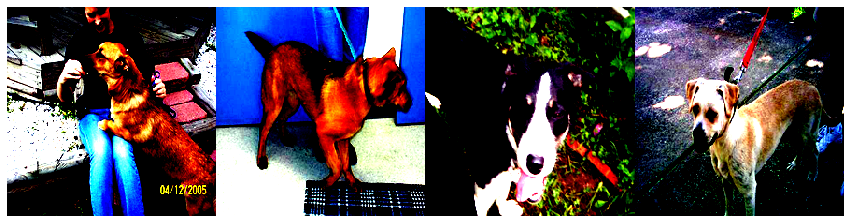

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


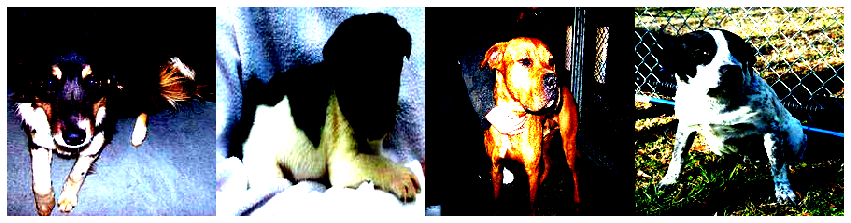

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


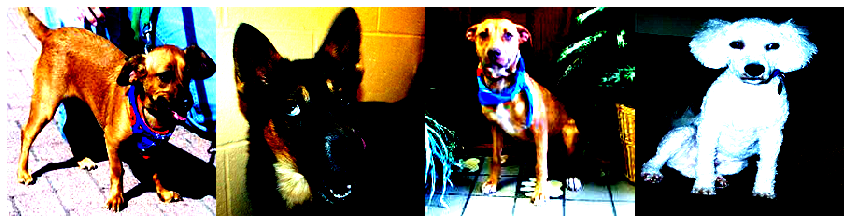

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


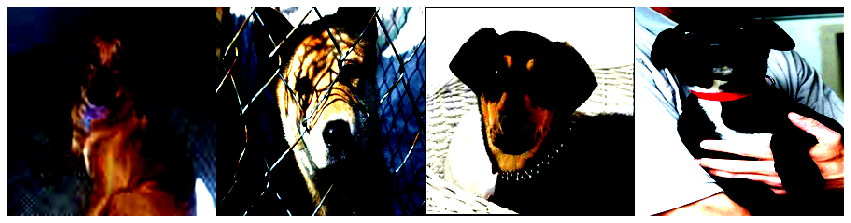

In [172]:
normalize_flow(img_size,batch_size,n)